# Noise Models

## Overview [Public API]

While quantum computers have the potential to be hugely powerful computing machines, it is in practice very difficult to realize large-scale quantum computation due to imperfections in the hardware.

In particular, noise is a huge obstacle to the experimental realization of quantum states (leading to the field of quantum error correction). Thus, it is important to be able to (as much as possible) predict the effects of noise in our design process.

We do this through a number of different noise models.

**NOTE:** this document only seeks to explain our noise models from a software design standpoint (not from a physics modelling standpoint).

# Initializing noise models [Public API]

We have many different parameterized noise models (we would expect users to know some characteristics are their system, and therefore to be able to pick the best one).

noiseless circuit output


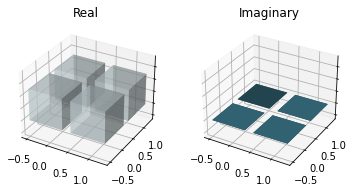

noisy circuit output


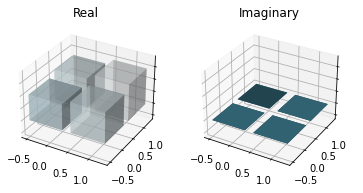

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [1]:
""" Noise model creation examples """
import numpy as np

import src.noise.noise_models as nm
import src.backends.density_matrix.functions as dmf

# No noise
no_noise = nm.NoNoise()

# Replace a gate by another (presumably similar) gate
# Use case 1: you have a small but systematic error in a gate implementation
# Use case 2: you have a window of error on the angle of your gates, and you want
# to quantify the effects on your circuit, at the maximum values of the window

# Suppose that we have a component not MEANT to change the circuit (identity)
# but which, upon fabrication, has a small effect
modified_identity = dmf.parameterized_one_qubit_unitary(10 * np.pi / 180, 0, 0)
qubit1_replacement = nm.OneQubitGateReplacement(modified_identity)

# Let's now build a circuit, with and without the noise
from src.circuit.circuit_dag import CircuitDAG
import src.circuit.ops as ops
from src.backends.density_matrix.compiler import DensityMatrixCompiler

compiler = DensityMatrixCompiler()

dag_noiseless = CircuitDAG(n_emitter=1, n_photon=0, n_classical=0)
dag_noiseless.add(ops.Hadamard(register=0, reg_type="e", noise=no_noise))
dag_noiseless.add(ops.Identity(register=0, reg_type="e", noise=no_noise))

dag_noisy = CircuitDAG(n_emitter=1, n_photon=0, n_classical=0)
dag_noisy.add(ops.Hadamard(register=0, reg_type="e", noise=no_noise))
dag_noisy.add(ops.Identity(register=0, reg_type="e", noise=qubit1_replacement))

print(f"noiseless circuit output")
compiler.compile(dag_noiseless).rep_data.draw()

print(f"noisy circuit output")
compiler.compile(dag_noisy).rep_data.draw()

Other examples of noise models can be seen in `./tests/test_noise`.

We won't look at the precise of each implementation or at every class (the APIs can be read from our documentation), but we will look at the different types of noise models (different subclasses of `NoiseBase`).

## Noise model classes and subclasses [Implementer Info]

### `NoiseBase`

`NoiseBase` is an abstract class. That is, it's not meant to be initialized. However, it defines the API for our noise models. Each `NoiseBase` object has:
* A dictionary, `self.noise_parameters` which contains (parameter name, parameter) pairs of the noise model. For example, in the example above, this would look like:"

```
noise_parameters = {"One-qubit unitary": <numpy array object>}
```
* A `get_backend_dependent_noise` function which takes some number of arguments (this depends on the class itself). This helper function is used by the third requirement for `NoiseBase` objects:
* An `apply(state_rep, n_quantum, reg_list)` function, which applies the noise in the representation `state_rep` (e.g. Density matrix), on a state of size `n_quantum`, on the registers in `reg_list`

**NOTE:** the noise objects are never manually applied by the user in our design process. The user only has to define the noise object, and the compiler takes care of the rest.

### Additive vs Replacement noise

We have two further base classes which both inherit from `NoiseBase`: `AdditionNoiseBase` and `ReplacementNoiseBase`.

`AdditionNoiseBase` is a class of noise which is applied either before or after the regular gate. It does not, however, get rid of the regular gate. Examples of this includes local clifford errors, depolarizing noise, etc.

`ReplacementNoiseBase` is a class of noise which is applied instead of the regular gate. It can be used to represent slightly faulty gates in the system.

These two classes are treated somewhat separately in the compilers; it is therefore useful to be aware of the distinction. Note that some incoming noise models (e.g. measurement error noise, or photon loss) may not fall into the categories above. However, for the time being, most noise should be one of these two types.

## Using a noise model in the solver [General API]

We'll go into details of how our solvers work in another jupyter notebook, but first let's reconsider our first (startup) example with additional noise.

C:\Users\julie\Documents\_graduate\git_repositories\graph-compiler\src\solvers\solver_base.py:41: UserWarning: Initial circuit for EvolutionarySolver is 'None'. 
  warnings.warn(f"Initial circuit for {self.__class__.__name__} is 'None'. ")


Iteration 0 | Best score: 0.7500
Iteration 1 | Best score: 0.7500
Iteration 2 | Best score: 0.7500
Iteration 3 | Best score: 0.7500
Iteration 4 | Best score: 0.7500
Iteration 5 | Best score: 0.7500
Iteration 6 | Best score: 0.5000
Iteration 7 | Best score: 0.5000
Iteration 8 | Best score: 0.5000
Iteration 9 | Best score: 0.5000
Iteration 10 | Best score: 0.5000
Iteration 11 | Best score: 0.0000
Iteration 12 | Best score: 0.0000
Iteration 13 | Best score: 0.0000
Iteration 14 | Best score: 0.0000
Iteration 15 | Best score: 0.0000
Iteration 16 | Best score: 0.0000
Iteration 17 | Best score: 0.0000
Iteration 18 | Best score: 0.0000
Iteration 19 | Best score: 0.0000
Iteration 20 | Best score: 0.0000
Iteration 21 | Best score: 0.0000
Iteration 22 | Best score: 0.0000
Iteration 23 | Best score: 0.0000
Iteration 24 | Best score: 0.0000
Iteration 25 | Best score: 0.0000
Iteration 26 | Best score: 0.0000
Iteration 27 | Best score: 0.0000
Iteration 28 | Best score: 0.0000
Iteration 29 | Best scor

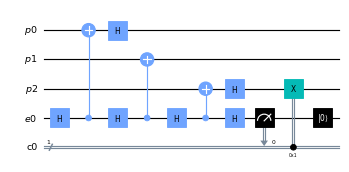

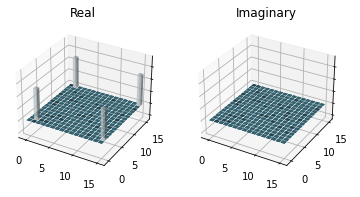

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [2]:
""" Setting up a solver: taken from quickstart """
import numpy as np

import src.backends.density_matrix.functions as dmf
from src.backends.density_matrix.compiler import DensityMatrixCompiler
from src.metrics import Infidelity
from src.state import QuantumState
from src.solvers.evolutionary_solver import EvolutionarySolver


ghz3_target_dm = dmf.ket2dm(
    (dmf.tensor(3 * [dmf.state_ketz0()]) + dmf.tensor(3 * [dmf.state_ketz1()]))
    / np.sqrt(2)
)
ghz3_target = QuantumState(ghz3_target_dm, rep_type="dm")

compiler = DensityMatrixCompiler()
DensityMatrixCompiler.measurement_determinism = 1

metric = Infidelity(target=ghz3_target)

solver_no_noise = EvolutionarySolver(
    target=ghz3_target,  # target state we want to achieve
    metric=metric,  # how we judge the quality of a solution
    compiler=compiler,  # how we simulate our solution
    n_emitter=1,  # number of emitter qubits available as resources
    n_photon=3,  # number of photons making up the target state
    noise_model_mapping=None,  # we ignore noise in this example
)
solver_no_noise.seed(
    1
)  # this will allow us to replicate results reliably (fixes the rng)
solver_no_noise.solve()


found_circuit = solver_no_noise.hof[0][1]
found_circuit.draw_circuit()
compiler.compile(found_circuit).dm.draw()

C:\Users\julie\Documents\_graduate\git_repositories\graph-compiler\src\solvers\solver_base.py:41: UserWarning: Initial circuit for EvolutionarySolver is 'None'. 
  warnings.warn(f"Initial circuit for {self.__class__.__name__} is 'None'. ")


Iteration 0 | Best score: 0.7562
Iteration 1 | Best score: 0.5239
Iteration 2 | Best score: 0.5239
Iteration 3 | Best score: 0.5239
Iteration 4 | Best score: 0.5237
Iteration 5 | Best score: 0.5237
Iteration 6 | Best score: 0.5237
Iteration 7 | Best score: 0.5237
Iteration 8 | Best score: 0.5237
Iteration 9 | Best score: 0.5237
Iteration 10 | Best score: 0.5133
Iteration 11 | Best score: 0.5035
Iteration 12 | Best score: 0.5035
Iteration 13 | Best score: 0.5035
Iteration 14 | Best score: 0.5035
Iteration 15 | Best score: 0.5035
Iteration 16 | Best score: 0.5035
Iteration 17 | Best score: 0.5035
Iteration 18 | Best score: 0.5035
Iteration 19 | Best score: 0.5035
Iteration 20 | Best score: 0.5035
Iteration 21 | Best score: 0.5035
Iteration 22 | Best score: 0.5035
Iteration 23 | Best score: 0.5035
Iteration 24 | Best score: 0.5035
Iteration 25 | Best score: 0.5035
Iteration 26 | Best score: 0.5035
Iteration 27 | Best score: 0.5035
Iteration 28 | Best score: 0.5035
Iteration 29 | Best scor

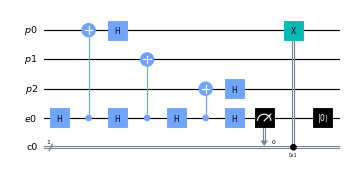

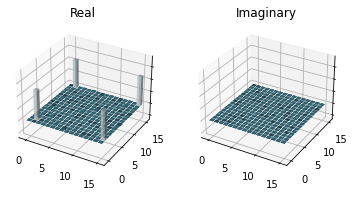

(<Figure size 432x288 with 2 Axes>,
 [<Axes3DSubplot:title={'center':'Real'}>,
  <Axes3DSubplot:title={'center':'Imaginary'}>])

In [3]:
""" Providing a noise model to the solver """

# Give a dictionary, where the key is the name of a component, and
# the value is the noise gate to apply

noise_model_mapping = {
    "Identity": nm.OneQubitGateReplacement(
        dmf.parameterized_one_qubit_unitary(np.pi / 180, 0, 0)
    ),
    "SigmaY": nm.PauliError("X"),
    "Hadamard": nm.DepolarizingNoise(0.01),
    "CNOT": nm.DepolarizingNoise(0.01),
}

solver_noise = EvolutionarySolver(
    target=ghz3_target,  # target state we want to achieve
    metric=metric,  # how we judge the quality of a solution
    compiler=compiler,  # how we simulate our solution
    n_emitter=1,  # number of emitter qubits available as resources
    n_photon=3,  # number of photons making up the target state
    noise_model_mapping=noise_model_mapping,
)
solver_noise.seed(1)  # this will allow us to replicate results reliably (fixes the rng)
solver_noise.solve()

found_circuit = solver_noise.hof[0][1]
found_circuit.draw_circuit()
compiler.compile(found_circuit).rep_data.draw()

Notice how the best per-iteration score did not match at each generation, and how the final score with noise could not reach an infidelity of zero (despite having designed the "correct" circuit).